Water Usage Efficiency (WUE) is a key sustainability metric for data centers, calculating the ratio of annual water usage (in liters) to the IT equipment energy (in kilowatt-hours).

The formula is $\frac{\text{Annual Water Usage (L)}}{\text{Annual IT Energy (kWh)}}$

Let's look into this dataset of climate conditions in African datacenters and their associated WUE score using fixed regular and cold-water approaches. We will use this to predict optimal WUE locations in the US based on climate conditions and grid renewable energy percentage.

In [2]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# lets first inspect the data

daily_df = pd.read_csv('data/daily_african_df.csv')

print(daily_df.head(5))

     city        date country climate_region  temperature  precipitation  \
0  Abomey  2022-08-20   Benin         Savana       24.108            1.3   
1  Abomey  2022-08-21   Benin         Savana       25.038            0.3   
2  Abomey  2022-08-22   Benin         Savana       24.712            4.2   
3  Abomey  2022-08-23   Benin         Savana       22.862           24.5   
4  Abomey  2022-08-24   Benin         Savana       24.100            1.9   

   wind_speed  humidity  wetbulb_temperature  \
0      10.833    78.458               70.176   
1       5.096    77.167               71.343   
2      12.529    77.500               70.874   
3      11.346    84.417               69.526   
4       8.008    81.042               70.719   

   Other renewables (including geothermal and biomass) - TWh  ...  \
0                                                0.0          ...   
1                                                0.0          ...   
2                                              

In [4]:
# Here we clean the column names and calculate energy usage as percentages
daily_df = daily_df.rename(columns={
    "WUE_FixedApproachDirect(L/KWh)": "WUE_Regular",
    "WUE_FixedColdWaterDirect(L/KWh)": "WUE_Coldwater",
    "Leakages (%)": "Leakages"
})
daily_df["renew_share"] = daily_df["Total renewables - TWh"] / daily_df["Total energy - TWh"]
daily_df["fossil_share"] = daily_df["Total fossil fuels - TWh"] / daily_df["Total energy - TWh"]
daily_df["nuclear_share"] = daily_df["Nuclear consumption - TWh"] / daily_df["Total energy - TWh"]

In [5]:
# since we are only interested in fitting a model for climate conditions + renewable energy, drop unneeded cols
cols_to_drop = [
    # other WUE definition
    "WUE_Indirect(L/KWh)",

    # redundant weather variables
    "temperature",
    "humidity",

    # raw energy totals (cause multicollinearity)
    "Total renewables - TWh",
    "Total fossil fuels - TWh",
    "Total energy - TWh",
    "Low carbon - TWh",
    "Other - TWh",

    # detailed generation types (already captured in shares)
    "Other renewables (including geothermal and biomass) - TWh",
    "Biofuels consumption - TWh",
    "Solar consumption - TWh",
    "Wind consumption - TWh",
    "Hydro consumption - TWh",
    "Gas consumption - TWh",
    "Coal consumption - TWh",
    "Oil consumption - TWh",
    "Nuclear consumption - TWh"
]

daily_df = daily_df.drop(columns=cols_to_drop)

# here we standardize the values to prevent inflation of condition number
cols = ["wetbulb_temperature","wind_speed","precipitation","renew_share"]
scaler = StandardScaler()
daily_df[cols] = scaler.fit_transform(daily_df[cols])

In [6]:
# fit a mixed effect (multilevel) regression model with coldwater WUE as the response
# we use city as the level as they will have persistent climate differences

# here we standardize the values to prevent inflation of condition number
cols = ["wetbulb_temperature","wind_speed","precipitation","renew_share"]
scaler = StandardScaler()
daily_df[cols] = scaler.fit_transform(daily_df[cols])

model = smf.mixedlm(
    "WUE_Coldwater ~ wetbulb_temperature + wind_speed + precipitation + renew_share",
    data=daily_df,
    groups=daily_df["city"]
)

result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  WUE_Coldwater
No. Observations:   110949   Method:              REML         
No. Groups:         306      Scale:               0.0016       
Min. group size:    122      Log-Likelihood:      200145.8805  
Max. group size:    483      Converged:           Yes          
Mean group size:    362.6                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            1.334    0.002 706.650 0.000  1.330  1.337
wetbulb_temperature  0.099    0.000 532.968 0.000  0.099  0.100
wind_speed          -0.005    0.000 -29.271 0.000 -0.006 -0.005
precipitation        0.001    0.000  10.039 0.000  0.001  0.002
renew_share         -0.006    0.002  -3.375 0.001 -0.010 -0.003
Group Var            0.001    0.002                  

/Users/jaydenudall/Desktop/datathon data/.venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
fixed_pred = result.fittedvalues            # fixed-effects predictions
var_resid = result.scale                    # residual variance
var_random = float(result.cov_re.iloc[0,0]) # random intercept variance
var_fixed = np.var(fixed_pred)              # variance of fixed predictions

# Marginal R squared (climate only)
R2_marginal = var_fixed / (var_fixed + var_random + var_resid)
print("Marginal R²:", R2_marginal)

Marginal R²: 0.8417077770472404


The mixed effect regression model gives us a high marginal R-squared value of 0.84, indicating that climate variables account for 84% of the variance in WUE. We also have significant p-values (p < 0.005) for every predictor. Our linear equation is:

$WUE = 1.334 + 0.099w - 0.005s + 0.001p - 0.006r$

where w = wetbulb temp, s = wind speed, p = precipitation, and r = renewable share

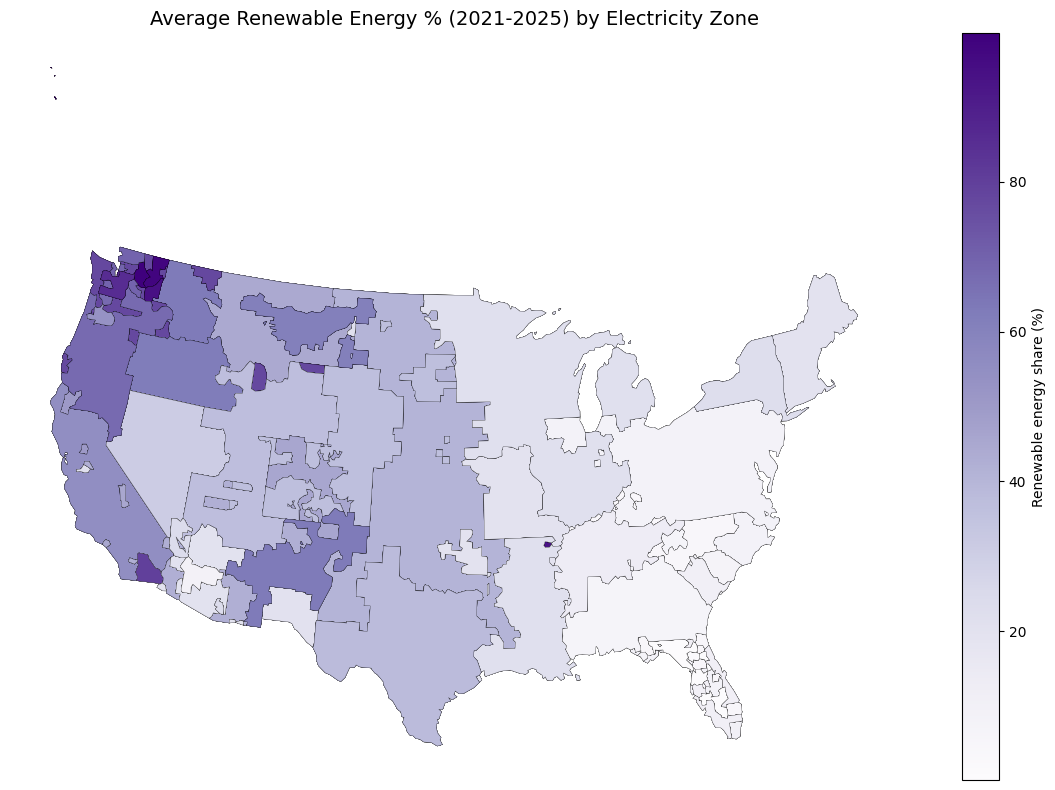

In [8]:
# now we pivot into laying predicted water efficiency over electrical grid regions

conus_gdf = gpd.read_file('geojson_files/conus_map.geojson')
electricity_df = pd.read_csv('data/electricity_data.csv')

# average over 2021-2025 for each zone
electricity_df_avg = (
    electricity_df
    .groupby(["zoneName", "sourceYear"])
    .mean(numeric_only=True)
    .reset_index()
)

conus_electricity_map = conus_gdf.merge(electricity_df_avg, on="zoneName", how="left")
conus_electricity_map = conus_electricity_map.to_crs("EPSG:5070")

fig, ax = plt.subplots(figsize=(13,8))

conus_electricity_map.plot(
    column="renewableEnergyPercentage",
    cmap="Purples",
    edgecolor="black",
    linewidth=0.15,
    legend=True,
    ax=ax,
    missing_kwds={"color":"lightgrey"},
    legend_kwds={"label": "Renewable energy share (%)"}
)
ax.set_title("Average Renewable Energy % (2021-2025) by Electricity Zone", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

### Map: Renewable energy share by U.S. electricity zone

The first map of `conus_electricity_map` shows **average renewable energy percentage (2021–2025)** across U.S. electricity zones. Darker shades in the chosen colormap represent **zones with a higher share of renewables**, while lighter or greyed-out regions mark **lower-renewable or missing-data areas**.

Analytically, this figure gives us the **supply-side decarbonization context**: it highlights where the grid is already relatively clean and where data center load would be powered by more fossil-heavy mixes. On its own, this map suggests **candidate regions for siting new data centers from a carbon perspective**, but it does **not yet account for water impacts** of cooling.

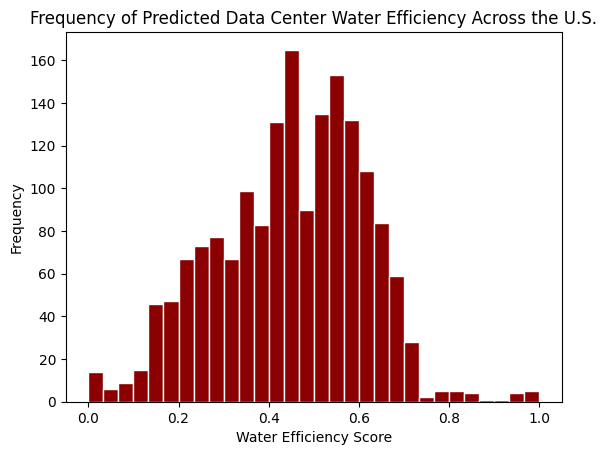

In [36]:
climdiv_gdf = gpd.read_file('data/CONUS_CLIMATE_DIVISIONS/GIS.OFFICIAL_CLIM_DIVISIONS.shp')
climate_df = pd.read_csv('data/climate_data.csv')

climdiv = climdiv_gdf.to_crs("EPSG:5070")
climdiv["geometry"] = climdiv.buffer(0)
climdiv = climdiv.merge(climate_df, on="CLIMDIV")

# calculate the representative point of each climate division
climdiv_pts = climdiv.copy()
climdiv_pts["geometry"] = climdiv.geometry.representative_point()
climdiv_pts = climdiv_pts.to_crs("EPSG:5070")

climdiv_pts = gpd.sjoin(
    climdiv_pts,
    conus_electricity_map[["zoneName", "renewableEnergyPercentage", "geometry"]],
    predicate="within",
    how="left"
)

# calculate the water efficiency score for each based on climate and energy factors
climdiv_pts["predicted_water_efficiency"] = (
    1.334
    + 0.099 * climdiv_pts["wetbulb"]
    - 0.005 * climdiv_pts["wind"]
    + 0.001 * climdiv_pts["precip"]
    - 0.006 * climdiv_pts["renewableEnergyPercentage"]
)

max_val = climdiv_pts["predicted_water_efficiency"].max()
min_val = climdiv_pts["predicted_water_efficiency"].min()

climdiv_pts["predicted_water_efficiency"] = (
    ((max_val - climdiv_pts["predicted_water_efficiency"]) / (max_val - min_val))
)

water_efficiencies = climdiv_pts["predicted_water_efficiency"]

plt.hist(water_efficiencies, bins=30, edgecolor='white', color='darkred')
plt.xlabel("Water Efficiency Score")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Data Center Water Efficiency Across the U.S.")
plt.show()

In [37]:
region_wue = (
    climdiv_pts
    .groupby("CLIMDIV")["predicted_water_efficiency"]
    .mean()
    .reset_index()
)

climdiv = climdiv.merge(region_wue, on="CLIMDIV", how="left")

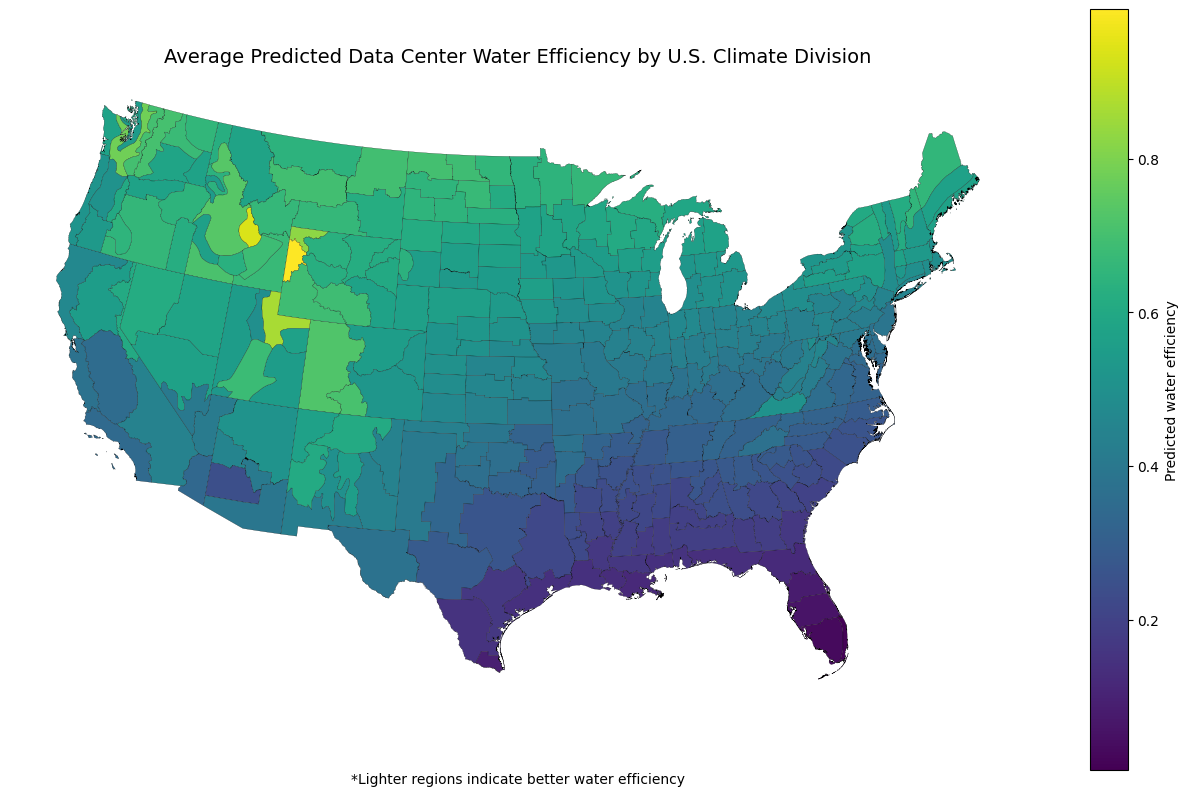

In [39]:
fig, ax = plt.subplots(figsize=(13,8))

climdiv.plot(
    column="predicted_water_efficiency",
    cmap="viridis",
    linewidth=0.15,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={"color":"lightgrey"},
    legend_kwds={"label": "Predicted water efficiency"}
)

ax.set_title("Average Predicted Data Center Water Efficiency by U.S. Climate Division", fontsize=14)
ax.text(0.5, -0.1, "*Lighter regions indicate better water efficiency", 
        ha='center', va='top', transform=ax.transAxes, fontsize=10)
ax.axis("off")
plt.tight_layout()
plt.show()

### Map: Predicted data center water efficiency by climate division

The map of `climdiv` polygons colored by `predicted_water_efficiency` translates the regression model into **spatial predictions** across U.S. climate divisions. By design, **lighter regions correspond to lower predicted water use per kWh (better WUE)**, and darker regions correspond to higher predicted water intensity.

Conceptually, this surface shows:
- **Cooler / less humid climates and/or higher-wind regions** tending toward **better predicted WUE** (lighter colors), where evaporative cooling can work more efficiently and require less water.
- **Hotter, more humid climates** tending toward **poorer predicted WUE** (darker colors), where cooling is water-intensive.

This figure is effectively a **water-efficiency suitability map** for data centers: without considering energy mix, it suggests which climate divisions are inherently more favorable for low water use given the modeled climate drivers.

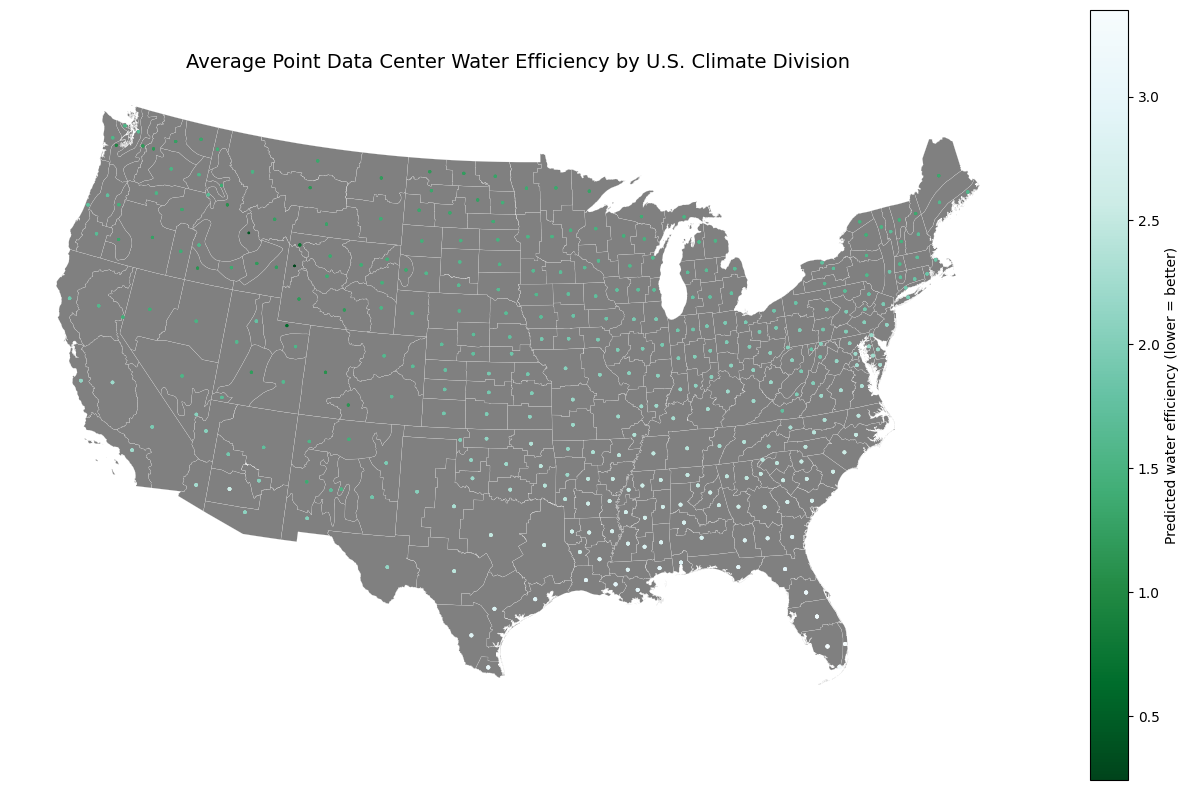

In [ ]:
fig, ax = plt.subplots(figsize=(13,8))

climdiv.plot(
    ax=ax,
    facecolor="grey",
    edgecolor="white",
    linewidth=0.1
)

climdiv_pts.plot(
    ax=ax,
    column="predicted_water_efficiency",
    cmap="BuGn",
    markersize=climdiv_pts["predicted_water_efficiency"],
    legend=True,
    legend_kwds={"label": "Predicted water efficiency"}
)

ax.set_title("Average Point Data Center Water Efficiency by U.S. Climate Division", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

### Map: Point-level predicted WUE over climate divisions

The figure that overlays `climdiv_pts` on top of a grey `climdiv` background shows **point-level predictions of WUE** within each climate division. Point colors and marker sizes both encode `predicted_water_efficiency`, making **clusters of especially efficient or inefficient locations** visually apparent inside broader regions.

Analytically, this map illustrates that:
- Even within the same climate division, **there can be meaningful local variation** in predicted water intensity.
- It helps identify **“micro-hotspots” of opportunity** (very low predicted WUE) or **risk** (very high predicted WUE) that might not be obvious from division-average values alone.

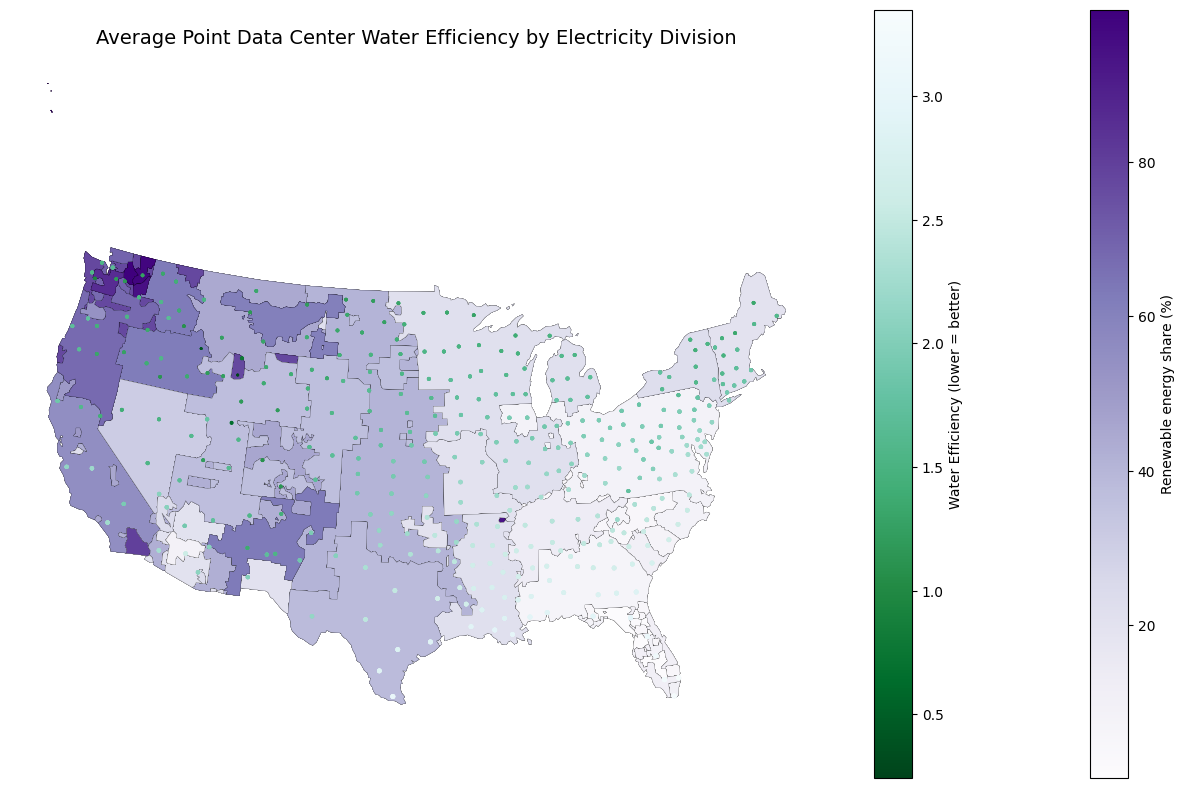

In [ ]:
fig, ax = plt.subplots(figsize=(13,8))

conus_electricity_map.plot(
    column="renewableEnergyPercentage",
    cmap="Purples",
    edgecolor="black",
    linewidth=0.1,
    legend=True,
    ax=ax,
    missing_kwds={"color":"lightgrey"},
    legend_kwds={"label": "Renewable energy share (%)"}
)

climdiv_pts.plot(
    ax=ax,
    column="predicted_water_efficiency",
    cmap="BuGn",
    markersize=climdiv_pts["predicted_water_efficiency"] * 2,
    legend=True,
    legend_kwds={"label": "Water Efficiency"}
)

ax.set_title("Average Point Data Center Water Efficiency by Electricity Division", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

Here we are overlaying the climate division point predicted water efficiency onto the map of electricity zones colored by renewable energy percentage. We can identify optimal points and regions from the darker green and purple colors, so the best locations for both renewable energy and water efficiency due to climate conditions would be dark purple regions with dark green dots. 

### Combined map: Renewable share + predicted WUE

The overlay map that plots `climdiv_pts` (predicted WUE) on top of `conus_electricity_map` (renewable energy %) provides a **joint view of decarbonization and water efficiency**. Here, the base color of each electricity zone indicates **grid cleanliness**, while the overlaid points show **how water-intensive cooling would be for a hypothetical data center in that location**.

This combined visualization lets us reason about **multi-objective siting**:
- **Best candidates** are areas where the **base map is dark (high renewables)** and the **overlaid WUE points are light and small (low water intensity)**.
- **Trade-off regions** are zones with either **high renewables but relatively water-intensive cooling**, or **good water efficiency but fossil-heavy grids**.
- The map thus surfaces **regions where additional policy or infrastructure (e.g., transmission, renewables build-out, or cooling tech changes)** could unlock both low-carbon and low-water data center locations.

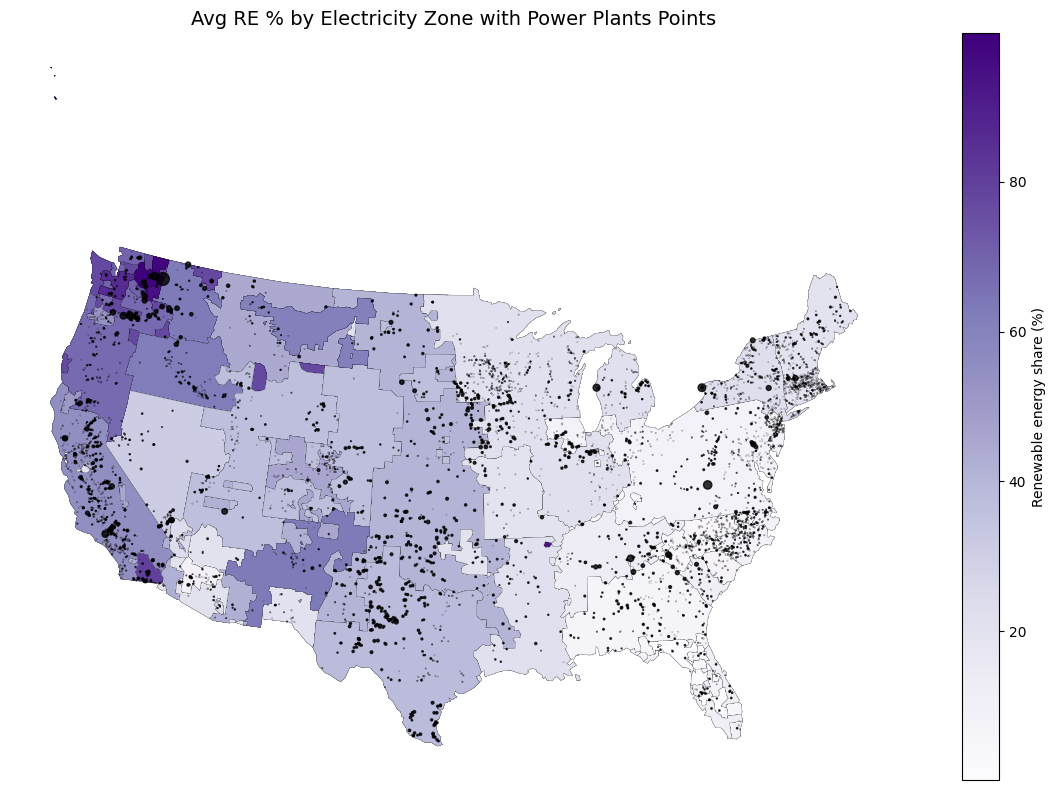

In [ ]:
plants_df = pd.read_csv("data/usa_power_plant_data.csv")
conus_gdf = gpd.read_file("geojson_files/conus_map.geojson")
renewables = ["Solar", "Wind", "Hydro", "Geothermal", "Biomass"]
plants_df = plants_df[plants_df["primary_fuel"].isin(renewables)]

plants_gdf = gpd.GeoDataFrame(
    plants_df,
    geometry=gpd.points_from_xy(plants_df.longitude, plants_df.latitude),
    crs="EPSG:4326"
)

plants_gdf = gpd.sjoin(
    plants_gdf,
    conus_gdf[["geometry"]],
    predicate="within",
    how="inner"
)

plants_gdf = plants_gdf.to_crs(conus_electricity_map.crs)
plants_gdf["size"] = plants_gdf["capacity_mw"] / 80

fig, ax = plt.subplots(figsize=(13,8))

conus_electricity_map.plot(
    column="renewableEnergyPercentage",
    cmap="Purples",
    edgecolor="black",
    linewidth=0.1,
    legend=True,
    ax=ax,
    missing_kwds={"color":"lightgrey"},
    legend_kwds={"label": "Renewable energy share (%)"}
)

plants_gdf.plot(
    ax=ax,
    markersize=plants_gdf["size"],
    color="black",
    alpha=0.8,
    zorder=3
)

ax.set_title("Avg RE % by Electricity Zone with Power Plants Points", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


### Map: Renewable plants over renewable share

The final map that overlays `plants_gdf` on the renewable share base map shows how **existing renewable generation capacity (sized by MW)** aligns with **zones of high renewable penetration**.

This serves two purposes:
1. It shows where **renewable capacity is already concentrated**, which can be advantageous for **connecting large loads like data centers** without large new build-outs.
2. When compared mentally with the WUE maps, it gives hints about where **existing renewable infrastructure and favorable cooling conditions might line up**—highlighting a subset of regions where **both climate-based water efficiency and renewable resource availability are promising**.

Overall, these maps move from **(1) climate-driven predictions of water use**, to **(2) spatial patterns of water efficiency**, and finally to **(3) integrated views that combine WUE with grid decarbonization and existing renewable infrastructure**—exactly the kind of multi-criteria perspective needed for sustainable data center siting.

Our current factors are:

1. Average predicted water efficiency from the 3 nearest climdiv points
2. Water scarcity (future or current)
3. Renewable energy percentage
4. Distance to nearest urban area (maximize to prevent noise pollution)